In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from pyDOE import lhs

import os
import time

plt.rcParams.update({'font.size':18})

def seed_torch(seed=42):
#     random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch(42)

In [2]:
l = 1
T = 0.5
k = 1
mu_2 = 1
mu_1 = 1e-5
p_in = 1
p_out = 0
nt = 1001
nx = 501

domain = (0, T, 0, l)
tmin, tmax, xmin, xmax = domain
mlp_layers = (2, 20, 20, 20, 20, 20, 1)
adam_epoch = 1000
newton_iter = 5000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_path = r'./model'
train_info_path = r'./'
if not os.path.exists(model_path):
    os.mkdir(model_path)

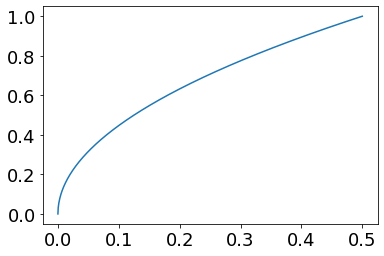

In [3]:
t = np.linspace(tmin, tmax, nt)
def _x_f(t):
    return (-mu_1*l + (mu_1**2*l**2 + 2*(mu_2-mu_1)*k*(p_in-p_out)*t)**0.5) / (mu_2-mu_1)
x_f = _x_f(t)
plt.plot(t, x_f)
plt.show()

In [4]:
x = np.linspace(xmin, xmax, nx)
tt, xx = np.meshgrid(t, x)
pp = np.zeros_like(tt)
for i in range(nx):
    for j in range(nt):
        x_f = _x_f(tt[i, j])
        if xx[i, j] < x_f:
            pp[i, j] = (-mu_2*(p_in-p_out))/((mu_2-mu_1)*x_f+mu_1*l)*xx[i, j] + p_in
        else:
            pp[i, j] = (-mu_1*(p_in-p_out))/((mu_2-mu_1)*x_f+mu_1*l)*xx[i, j] + (mu_1*(p_in-p_out))/((mu_2-mu_1)*x_f+mu_1*l) + p_out

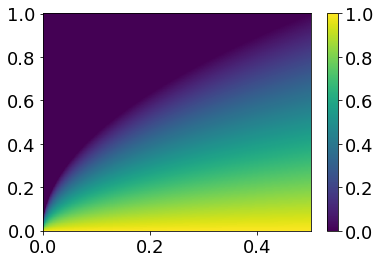

In [5]:
plt.pcolor(tt, xx, pp)
plt.colorbar()

## 数据集生成

In [6]:
class DatasetInjection:
    def __init__(self, domain):
        self.domain = domain
        tmin, tmax, xmin, xmax = self.domain
        self.lb = np.array([tmin, xmin])
        self.ub = np.array([tmax, xmax])
    
    def train_data(self, verbose=None):
        tmin, tmax, xmin, xmax = self.domain
        # 内部点采样
        t_res = np.linspace(tmin, tmax, 51)[1:]
        x_res = np.linspace(xmin, xmax, 51)[1:-1]
        X_res1 = self.sample_xy(t_res, x_res)
        X_res2 = self.sample_xy(t_res, x_res)
        X_res3 = self.sample_xy(t_res, x_res)
        # 初始点采样
        X_ics = self.sample_xy(np.array([tmin]), np.linspace(xmin, xmax, 100))
        u_ics = X_ics[:, [1]]**2 * np.cos(np.pi * X_ics[:, [1]])
        # 边界点采样
        X_bcs_in = self.sample_xy(np.linspace(tmin, tmax, 100), np.array([xmin]))
        X_bcs_out = self.sample_xy(np.linspace(tmin, tmax, 100), np.array([xmax]))
        return X_res1, X_res2, X_res3, X_ics, X_bcs_in, X_bcs_out
    
    def sample_xy(self, x, y):
        xx, yy = np.meshgrid(x, y)
        X = np.concatenate([xx.reshape((-1, 1)), yy.reshape((-1, 1))], axis=1)
        return X
    
    def lhs_sample_xy(self, n=10000):
        X = (self.ub - self.lb) * lhs(2, n) + self.lb
        return X
    

dataset = DatasetInjection(domain)
X_res1, X_res2, X_res3, X_ics, X_bcs_in, X_bcs_out = dataset.train_data()
print(X_res1.shape, X_res1.shape, X_res1.shape, X_ics.shape, X_bcs_in.shape, X_bcs_out.shape)

(2450, 2) (2450, 2) (2450, 2) (100, 2) (100, 2) (100, 2)


## PINN主干网络

In [7]:
class MLP(nn.Module):
    def __init__(self, mlp_layers, add_sigmoid=False):
        super(MLP, self).__init__()
        self.model = nn.Sequential()
        for i in range(len(mlp_layers)-2):
            self.model.add_module(f'fc{i+1}', nn.Linear(mlp_layers[i], mlp_layers[i+1], bias=True))
            self.model.add_module(f'act{i+1}', nn.Tanh())
        self.model.add_module(f'fc{len(mlp_layers)-1})', nn.Linear(mlp_layers[-2], mlp_layers[-1], bias=False))
        if add_sigmoid:
            self.model.add_module('add_sigmoid', nn.Sigmoid())
    
    def forward(self, X):
        return self.model(X)
    
    
mlp = MLP(mlp_layers, add_sigmoid=True)
mlp.model

Sequential(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (act1): Tanh()
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (act2): Tanh()
  (fc3): Linear(in_features=20, out_features=20, bias=True)
  (act3): Tanh()
  (fc4): Linear(in_features=20, out_features=20, bias=True)
  (act4): Tanh()
  (fc5): Linear(in_features=20, out_features=20, bias=True)
  (act5): Tanh()
  (fc6)): Linear(in_features=20, out_features=1, bias=False)
  (add_sigmoid): Sigmoid()
)

## PINN模型

In [8]:
def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True, 
                               retain_graph=True)

In [9]:
class PINNInjection(nn.Module):
    def __init__(self, nn_v, nn_p, nn_c):
        super(PINNInjection, self).__init__()
        self.nn_v = nn_v
        self.nn_p = nn_p
        self.nn_c = nn_c
    
    def forward(self, X_res1, X_res2, X_res3, X_ics, X_bcs_in, X_bcs_out):
        loss_f1, loss_f2, loss_f3 = self.net_f(X_res1, X_res2, X_res3)
        loss_p = self.net_p(X_bcs_in, X_bcs_out)
        loss_c = self.net_c(X_bcs_in, X_ics)
        return loss_f1, loss_f2, loss_f3, loss_p, loss_c
    
    def net_u(self, X):
        v = self.nn_v(X)
        p = self.nn_p(X)
        c = self.nn_c(X)
        return v, p, c
    
    def net_f(self, X_res1, X_res2, X_res3):
        f1 = self.net_f1(X_res1)
        f2 = self.net_f2(X_res2)
        f3 = self.net_f3(X_res3)
        return torch.mean(f1**2), torch.mean(f2**2), torch.mean(f3**2)
    
    def net_f1(self, X_res1):
        X_res1.requires_grad_(True)
        v = self.nn_v(X_res1)
        c = self.nn_c(X_res1)
        
        grad_c = grad(c, X_res1)[0]
        c_t = grad_c[:, [0]]
        c_x = grad_c[:, [1]]
        
        f1 = c_t + v * c_x
        X_res1.detach_()
        return f1
    
    def net_f2(self, X_res2):
        X_res2.requires_grad_(True)
        v = self.nn_v(X_res2)
        p = self.nn_p(X_res2)
        c = self.nn_c(X_res2)
        
        grad_p = grad(p, X_res2)[0]
        p_x = grad_p[:, [1]]
        
        f2 = v + k / (c * mu_2 + (1-c) * mu_1) * p_x
        X_res2.detach_()
        return f2
    
    def net_f3(self, X_res3):
        X_res3.requires_grad_(True)
        v = self.nn_v(X_res3)
        
        grad_v = grad(v, X_res3)[0]
        v_x = grad_v[:, [1]]
        
        f3 = v_x
        X_res3.detach_()
        return f3
    
    def net_p(self, X_bcs_in, X_bcs_out):
        p_in_pred = self.nn_p(X_bcs_in)
        p_out_pred = self.nn_p(X_bcs_out)
        loss_p = torch.mean((p_in_pred - p_in)**2) + torch.mean((p_out_pred - p_out)**2)
        return loss_p
    
    def net_c(self, X_bcs_in, X_ics):
        c_in_pred = self.nn_c(X_bcs_in)
        c_ics = self.nn_c(X_ics)
        loss_c = torch.mean((c_in_pred-1)**2) + torch.mean(c_ics**2)
        return loss_c
    

nn_v = MLP(mlp_layers)
nn_p = MLP(mlp_layers)
nn_c = MLP(mlp_layers)
pinn = PINNInjection(nn_v, nn_p, nn_c)

In [10]:
def prob_resample(X_resami, net_fi, num=1000, eps=0.01, plot=True):
    # 获得residule
    fi = net_fi(X_resami)
    fi = fi.detach().cpu().numpy()
    # 计算概率权重
    prob = np.concatenate([np.log(abs(fi / eps) + np.finfo(np.float32).eps), np.zeros(fi.shape)], axis=1)
    prob = np.max(prob, axis=1)
    prob = prob / sum(prob)
    # np.random.choice得到索引
    idx = np.random.choice(X_resami.shape[0], num, replace=True, p=prob)
    
    if plot:
        x = X_resami.detach().cpu().numpy()[:, 0]
        y = X_resami.detach().cpu().numpy()[:, 1]
        log_abs_f = np.log(abs(fi) + np.finfo(np.float32).eps)
        fig = plt.figure(figsize=(20, 5))
        ax = fig.add_subplot(131)
        plt.scatter(x, y, c=log_abs_f, s=10)
        plt.colorbar()
        plt.xlim([0, 0.5])
        plt.ylim([0, 1])
        plt.title('f log(abs($\cdot$))')
        ax.set_aspect(1./ax.get_data_ratio())
        
        ax = fig.add_subplot(132)
        plt.scatter(x, y, c=prob, s=10)
        plt.colorbar()
        plt.xlim([0, 0.5])
        plt.ylim([0, 1])
        plt.title('p')
        ax.set_aspect(1./ax.get_data_ratio())
        
        ax = fig.add_subplot(133)
        plt.scatter(x[idx], y[idx], c=log_abs_f[idx], s=10)
        plt.colorbar()
        plt.xlim([0, 0.5])
        plt.ylim([0, 1])
        plt.title('added points')
        ax.set_aspect(1./ax.get_data_ratio())
        plt.tight_layout()
        plt.show()
    return X_resami[idx].detach()

In [11]:
def easy_resample(dataset, net_f, i, device=torch.device('cuda'), n_total_points=10000, n_added_points=1000, plot=True):
    # 生成待采样的点集
    X_resam = dataset.lhs_sample_xy(n=n_total_points)
    X_resam = torch.from_numpy(X_resam).float().to(device)
    # 获得residule
    f = net_f(X_resam)
    f = f.detach().cpu().numpy()
    # 依loss_res的值排序得到索引
    idx = np.argsort(abs(f).flatten())[-n_added_points:]
    
    if plot:
        x = X_resam[:, 0].detach().cpu().numpy()
        y = X_resam[:, 1].detach().cpu().numpy()
        fig = plt.figure(figsize=(13, 5))
        ax = fig.add_subplot(121)
        plt.scatter(x, y, c=abs(f), s=10)
        plt.colorbar()
        plt.xlabel(r'$t$')
        plt.ylabel(r'$x$')
        plt.xlim([0, 0.5])
        plt.ylim([0, 1])
        plt.title(f'f{i}')
        ax.set_aspect(1./ax.get_data_ratio())
        ax = fig.add_subplot(122)
        plt.scatter(x[idx], y[idx], c=abs(f[idx]), s=10)
        plt.colorbar()
        plt.xlabel(r'$t$')
        plt.ylabel(r'$x$')
        plt.xlim([0, 0.5])
        plt.ylim([0, 1])
        plt.title('Added points')
        ax.set_aspect(1./ax.get_data_ratio())
        plt.tight_layout()
        plt.savefig(f'./f{i}_resample.png', dpi=100)
        plt.show()
    return X_resam[idx].detach()

## Adam + BFGS + ProbResample 优化

Epoch #  100/1000	time:2.4e+00	loss:2.61e-01, loss_f1:1.39e-04, loss_f2:4.21e-02, loss_f3:2.76e-04, loss_p:1.23e-01, loss_c:9.54e-02
Epoch #  200/1000	time:4.7e+00	loss:2.02e-01, loss_f1:6.46e-03, loss_f2:2.45e-02, loss_f3:4.89e-04, loss_p:7.63e-02, loss_c:9.45e-02
Epoch #  300/1000	time:7.3e+00	loss:1.53e-01, loss_f1:2.37e-03, loss_f2:2.09e-02, loss_f3:1.20e-03, loss_p:4.84e-02, loss_c:8.02e-02
Epoch #  400/1000	time:1.1e+01	loss:1.27e-01, loss_f1:1.24e-03, loss_f2:1.92e-02, loss_f3:6.80e-04, loss_p:3.87e-02, loss_c:6.70e-02
Epoch #  500/1000	time:1.4e+01	loss:1.04e-01, loss_f1:2.31e-03, loss_f2:1.65e-02, loss_f3:2.34e-04, loss_p:2.50e-02, loss_c:6.00e-02
Epoch #  600/1000	time:1.7e+01	loss:9.22e-02, loss_f1:3.52e-03, loss_f2:1.39e-02, loss_f3:2.49e-04, loss_p:1.72e-02, loss_c:5.73e-02
Epoch #  700/1000	time:2.0e+01	loss:8.30e-02, loss_f1:3.60e-03, loss_f2:1.25e-02, loss_f3:2.22e-04, loss_p:1.41e-02, loss_c:5.25e-02
Epoch #  800/1000	time:2.3e+01	loss:7.59e-02, loss_f1:3.63e-03, loss_

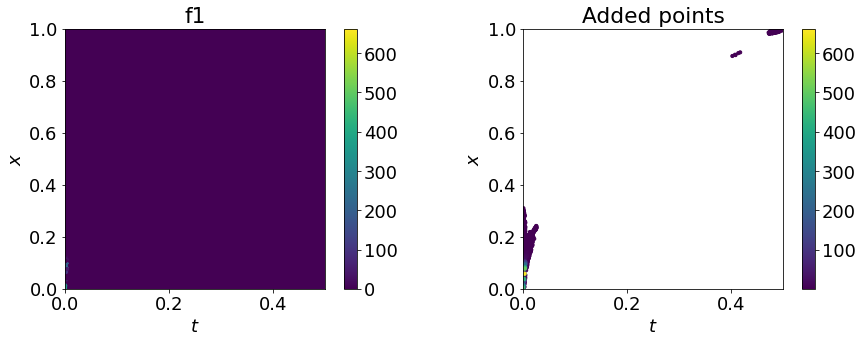

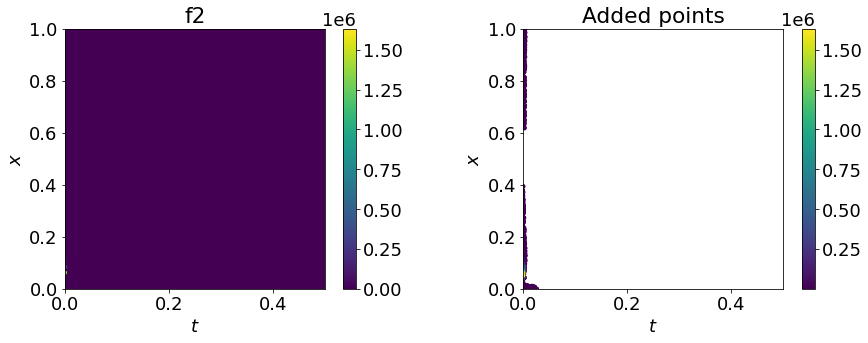

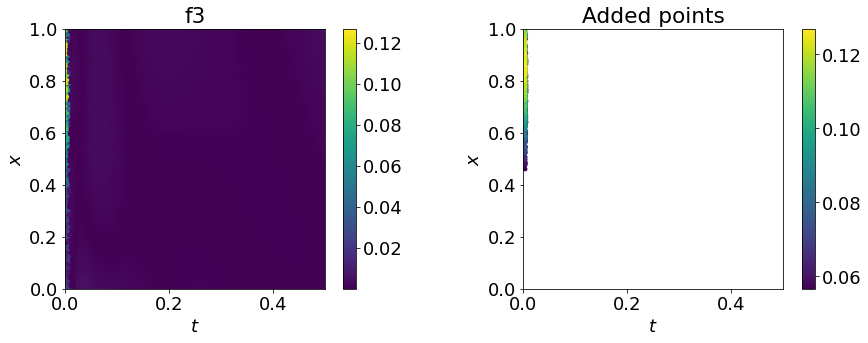

torch.Size([2450, 2])
torch.Size([2950, 2])
Test Epoch # 1000	loss:5.10e-03, loss_f1:8.34e-06, loss_f2:6.22e-05, loss_f3:2.06e-06, loss_p:1.29e-05, loss_c:5.02e-03


In [13]:
# 生成训练数据
dataset = DatasetInjection(domain)
X_res1, X_res2, X_res3, X_ics, X_bcs_in, X_bcs_out = dataset.train_data()
X_res1 = torch.from_numpy(X_res1).float().to(device)
X_res2 = torch.from_numpy(X_res2).float().to(device)
X_res3 = torch.from_numpy(X_res3).float().to(device)
X_ics = torch.from_numpy(X_ics).float().to(device)
X_bcs_in = torch.from_numpy(X_bcs_in).float().to(device)
X_bcs_out = torch.from_numpy(X_bcs_out).float().to(device)
# 生成测试数据
X_res1_test, X_res2_test, X_res3_test, X_ics_test, X_bcs_in_test, X_bcs_out_test = dataset.train_data()
X_res1_test = torch.from_numpy(X_res1_test).float().to(device)
X_res2_test = torch.from_numpy(X_res2_test).float().to(device)
X_res3_test = torch.from_numpy(X_res3_test).float().to(device)
X_ics_test = torch.from_numpy(X_ics_test).float().to(device)
X_bcs_in_test = torch.from_numpy(X_bcs_in_test).float().to(device)
X_bcs_out_test = torch.from_numpy(X_bcs_out_test).float().to(device)
# 初始化网络结构
nn_v = MLP(mlp_layers, add_sigmoid=False)
nn_p = MLP(mlp_layers, add_sigmoid=True)
nn_c = MLP(mlp_layers, add_sigmoid=True)
pinn = PINNInjection(nn_v, nn_p, nn_c)
pinn = pinn.to(device)
optimizer_adam = optim.Adam(pinn.parameters(), lr=1e-3)
loss_log = []
best_loss = 1e9

n_total_points = 80000
n_added_points = 500
# eps1 = 1e-5
# eps2 = 1e-4
# eps3 = 1e-4

with open(train_info_path + 'train_info.txt', 'w') as f:
    f.write('Training by Adam:\n')
start_time = time.time()

for epoch in range(adam_epoch):
    
    ############################################## Adam ##############################################
    pinn.zero_grad()
    loss_f1, loss_f2, loss_f3, loss_p, loss_c = pinn(X_res1, X_res2, X_res3, X_ics, X_bcs_in, X_bcs_out)
    loss = loss_f1 + loss_f2 + loss_f3 + loss_p + loss_c
    loss.backward()
    optimizer_adam.step()
    
    loss_log.append(loss.item())
        
    if (epoch + 1) % 100 == 0:  # 打印训练信息
        info = f'Epoch # {epoch+1:4d}/{adam_epoch}\ttime:{time.time()-start_time:.1e}\t' + f'loss:{loss.item():.2e}, loss_f1:{loss_f1.item():.2e}, loss_f2:{loss_f2.item():.2e}, loss_f3:{loss_f3.item():.2e}, loss_p:{loss_p.item():.2e}, loss_c:{loss_c.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        model_state = {'epoch': epoch+1, 'state_dict': pinn.state_dict()}
        backbone_path = os.path.join(model_path, f'pinn_adam_{epoch+1}.pth')
        torch.save(model_state, backbone_path)
    ############################################## Adam ##############################################
            
    if (epoch + 1) % 1000 == 0:  # 每1000次adam后采用BFGS优化并重采样
        
        ############################################## BFGS ##############################################
        optimizer_lbfgs = optim.LBFGS(pinn.parameters(), max_iter=newton_iter, history_size=newton_iter,  # 调大history_size等价于BFGS
                                      tolerance_grad=1.e-6, tolerance_change=1.e-10, line_search_fn="strong_wolfe")
        it = 0  # BFGS迭代次数
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write('Training by LBFGS:\n')

        def closure():
            global it
            pinn.zero_grad()
            loss_f1, loss_f2, loss_f3, loss_p, loss_c = pinn(X_res1, X_res2, X_res3, X_ics, X_bcs_in, X_bcs_out)
            loss = loss_f1 + loss_f2 + loss_f3 + loss_p + loss_c
            loss.backward()
            loss_log.append(loss.item())
            if (it + 1) % 100 == 0:
                info = f'Iter # {it+1:4d}\ttime:{time.time()-start_time:.1e}\t' + f'loss:{loss.item():.2e}, loss_f1:{loss_f1.item():.2e}, loss_f2:{loss_f2.item():.2e}, loss_f3:{loss_f3.item():.2e}, loss_p:{loss_p.item():.2e}, loss_c:{loss_c.item():.2e}'
                with open(train_info_path + 'train_info.txt', 'a') as f:
                    f.write(info + '\n')
                print(info)
            it = it + 1
            return loss
        optimizer_lbfgs.step(closure)

        model_state = {'state_dict': pinn.state_dict()}
        backbone_path = os.path.join(model_path, f'pinn_lbfgs_{epoch+1}.pth')
        torch.save(model_state, backbone_path)
        ############################################## BFGS ##############################################

        ############################################## Prob Resample ##############################################
        pinn.zero_grad()
        pinn.eval()
        # 重采样
        X_resam1 = easy_resample(dataset, pinn.net_f1, 1, device=device, n_total_points=n_total_points, n_added_points=n_added_points, plot=True)
        X_resam2 = easy_resample(dataset, pinn.net_f2, 2, device=device, n_total_points=n_total_points, n_added_points=n_added_points, plot=True)
        X_resam3 = easy_resample(dataset, pinn.net_f3, 3, device=device, n_total_points=n_total_points, n_added_points=n_added_points, plot=True)
        # 拼接数据
        print(X_res1.shape)
        X_res1 = torch.cat([X_res1, X_resam1], dim=0)
        X_res2 = torch.cat([X_res2, X_resam2], dim=0)
        X_res3 = torch.cat([X_res3, X_resam3], dim=0)
        print(X_res1.shape)
        pinn.train()
        ############################################## Prob Resample ##############################################
        
        ############################################## Calculate the residues' mean ##############################################
        pinn.eval()
        # 计算控制循环的mu
        pinn.zero_grad()
        loss_f1_test, loss_f2_test, loss_f3_test, loss_p_test, loss_c_test = pinn(X_res1_test, X_res2_test, X_res3_test, X_ics_test, X_bcs_in_test, X_bcs_out_test)
        loss_test = loss_f1_test + loss_f2_test + loss_f3_test + loss_p_test + loss_c_test
        info = f'Test Epoch # {epoch+1:4d}\t' + f'loss:{loss_test.item():.2e}, loss_f1:{loss_f1_test.item():.2e}, loss_f2:{loss_f2_test.item():.2e}, loss_f3:{loss_f3_test.item():.2e}, loss_p:{loss_p_test.item():.2e}, loss_c:{loss_c_test.item():.2e}'
        with open(train_info_path + 'train_info.txt', 'a') as f:
            f.write(info + '\n')
        print(info)
        if loss_test.item() < best_loss:
            # 保存loss最低的模型
            model_state = {'epoch': epoch+1, 'info': info, 'state_dict': pinn.state_dict()}
            torch.save(model_state, os.path.join(model_path, f'pinn_best.pth'))
            best_loss = loss_test.item()
#         mu1 = loss_f1_test.item()**0.5
#         mu2 = loss_f2_test.item()**0.5
#         mu3 = loss_f3_test.item()**0.5
#         print(f'mu\t{mu1:.2e}\t{mu2:.2e}\t{mu3:.2e}')
#         print(f'eps\t{eps1:.2e}\t{eps2:.2e}\t{eps3:.2e}')
#         # 若mu小于eps则循环退出
#         if (mu1 < eps1) and (mu2 < eps2) and (mu3 < eps3):
#             print(f'mu less than eps, break. epoch: {(epoch + 1)}')
#             break
        pinn.train()
        ############################################## Calculate the residues' mean ##############################################

In [ ]:
plt.plot(loss_log)
plt.yscale('log')
plt.title

In [ ]:
nn_v = MLP(mlp_layers, add_sigmoid=False)
nn_p = MLP(mlp_layers, add_sigmoid=True)
nn_c = MLP(mlp_layers, add_sigmoid=True)
pinn = PINNInjection(nn_v, nn_p, nn_c)
pinn = pinn.to(device)

model_state = torch.load(os.path.join(model_path, f'pinn_lbfgs_1000.pth'))
pinn.load_state_dict(model_state['state_dict'])

In [ ]:
TX = np.concatenate([tt.reshape(-1, 1), xx.reshape(-1, 1)], axis=1)
TX = torch.from_numpy(TX).float().to(device)
v_pred, p_pred, c_pred = pinn.net_u(TX)
v_pred = v_pred.detach().cpu().numpy().reshape(tt.shape)
p_pred = p_pred.detach().cpu().numpy().reshape(tt.shape)
c_pred = c_pred.detach().cpu().numpy().reshape(tt.shape)

In [ ]:
error = np.linalg.norm(p_pred - pp) / np.linalg.norm(pp) 
print('Relative l2 error: {:.3e}'.format(error))

In [ ]:
# parameters = {'axes.labelsize': 18,
#               'figure.titlesize': 108,
#               'xtick.labelsize': 18,
#               'ytick.labelsize': 18,
#               'legend.fontsize': 18}
# plt.rcParams.update(parameters)

plt.rcParams.update({'font.size':18})

In [ ]:
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(1, 3, 1)
plt.pcolor(tt, xx, pp, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $p(t, x)$')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())

ax = fig.add_subplot(1, 3, 2)
plt.pcolor(tt, xx, p_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $p(t, x)$')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())

ax = fig.add_subplot(1, 3, 3)
plt.pcolor(tt, xx, np.abs(pp - p_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
ax.set_aspect(1./ax.get_data_ratio())
plt.savefig('./probResample_result.png', dpi=100)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
plt.plot(x, pp[:,1], color='k')
plt.plot(x, p_pred[:,1], ':', color='red')

plt.plot(x, pp[:,75], color='k')
plt.plot(x, p_pred[:,75], ':', color='red')

plt.plot(x, pp[:,250], color='k')
plt.plot(x, p_pred[:,250], ':', color='red')

plt.plot(x, pp[:,-1], color='k', label='Analytical')
plt.plot(x, p_pred[:,-1], ':', color='red', label='New Adaptive PINN')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$p(t, x)$')
plt.title('$t = 0, 0.15, 0.25, 0.5$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('p_at_different_times.png', dpi=100)
plt.show()